# Análisis rápido 

Notebook para inspección rápida de artefactos generados por el pipeline: cargas, métricas, gráficos y diagnóstico de unidades con peor rendimiento.

In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path('..')  # notebook ubicado en src/notebooks -> ../ = src
PIPE_OUT = ROOT / 'pipeline_outputs'
MODELS = ROOT / 'models'
print('PIPE_OUT:', PIPE_OUT.resolve())
print('MODELS:', MODELS.resolve())
print('\nArtifacts present:')
for p in sorted(list(PIPE_OUT.glob('*')) + list(MODELS.glob('*'))):
    print('-', p.name)

PIPE_OUT: C:\Users\jucep\OneDrive\Escritorio\Proyecto CMAPSS\mantenimiento-predictivo\src\pipeline_outputs
MODELS: C:\Users\jucep\OneDrive\Escritorio\Proyecto CMAPSS\mantenimiento-predictivo\src\models

Artifacts present:
- feature_importance.csv
- metrics_summary.csv
- model_xgb_fold0.bin
- model_xgb_fold1.bin
- model_xgb_fold2.bin
- model_xgb_fold3.bin
- model_xgb_fold4.bin
- preds_val_fold0.csv
- preds_val_fold0_smoothed.csv
- preds_val_fold1.csv
- preds_val_fold2.csv
- preds_val_fold3.csv
- preds_val_fold4.csv
- features.json
- metadata.json
- pipeline_log.txt
- plots
- scaler.pkl
- scaler_roundtrip.pkl
- validation_tests.log
- X_test.parquet
- X_train.parquet
- y_train.parquet


In [2]:
# Cargar datos principales
X_train = pd.read_parquet(PIPE_OUT / 'X_train.parquet')
y_train = pd.read_parquet(PIPE_OUT / 'y_train.parquet')
X_test = pd.read_parquet(PIPE_OUT / 'X_test.parquet') if (PIPE_OUT / 'X_test.parquet').exists() else None
with open(PIPE_OUT / 'metadata.json','r',encoding='utf-8') as f:
    metadata = json.load(f)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('metadata sample:')
print(json.dumps({k: metadata.get(k) for k in ['date_utc','n_units','n_rows_train','scaler_type']}, indent=2))

X_train shape: (20631, 269)
y_train shape: (20631, 3)
metadata sample:
{
  "date_utc": "2025-11-23T23:14:37.914117",
  "n_units": 100,
  "n_rows_train": 20631,
  "scaler_type": "StandardScaler-fast"
}


In [3]:
# Cargar predicciones (ej. fold0) si están disponibles
pred_csv = MODELS / 'preds_val_fold0.csv'
if pred_csv.exists():
    preds = pd.read_csv(pred_csv)
    print('Loaded preds from', pred_csv.name, 'shape=', preds.shape)
else:
    preds = None
    print('No preds file found at', pred_csv)

Loaded preds from preds_val_fold0.csv shape= (4120, 4)


In [4]:
# Métricas simples (RMSE, MAE) y PHM08 proxy
def rmse(a,b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    return float(np.sqrt(np.mean((a-b)**2)))
def mae(a,b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    return float(np.mean(np.abs(a-b)))
def phm08_proxy(a,b):
    return -rmse(a,b)

if preds is not None and ('y_true' in preds.columns or 'y' in preds.columns):
    tcol = 'y_true' if 'y_true' in preds.columns else 'y'
    pcol = 'y_pred' if 'y_pred' in preds.columns else 'yhat' if 'yhat' in preds.columns else None
    if pcol is None:
        print('No prediction column recognised in preds file; expected y_pred or yhat')
    else:
        r = rmse(preds[tcol], preds[pcol])
        m = mae(preds[tcol], preds[pcol])
        ph = phm08_proxy(preds[tcol], preds[pcol])
        print(f"Samples: {len(preds)} — RMSE: {r:.2f}  MAE: {m:.2f}  PHM08_proxy: {ph:.2f}")
else:
    print('Predictions not available or missing y_true column; skipping metrics')

Samples: 4120 — RMSE: 37.98  MAE: 23.01  PHM08_proxy: -37.98


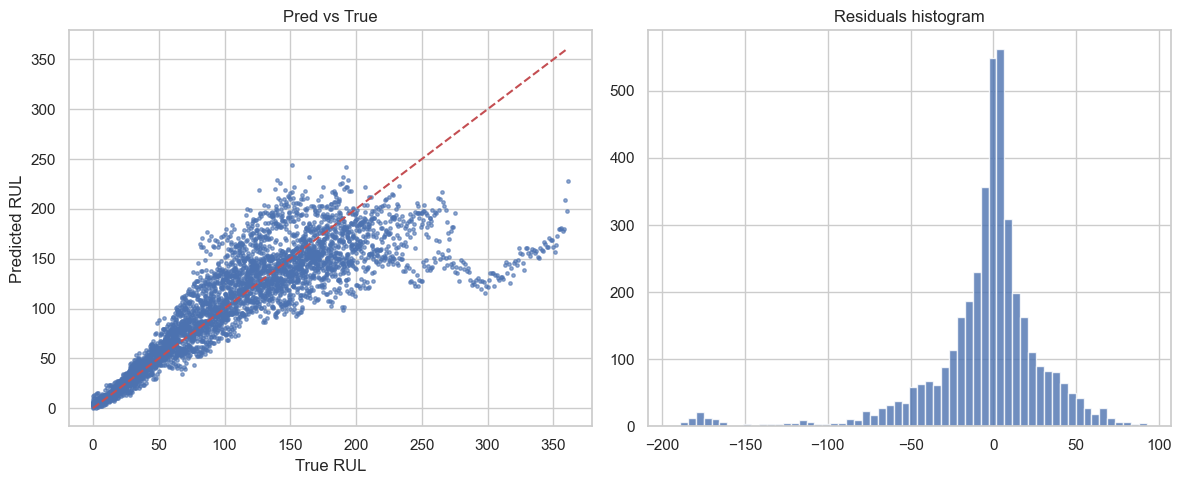

In [5]:
# Gráficos: pred vs true, residuals
import seaborn as sns
sns.set(style='whitegrid')
if preds is not None and pcol is not None:
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    ax0, ax1 = ax
    ax0.scatter(preds[tcol], preds[pcol], s=6, alpha=0.6)
    ax0.plot([preds[tcol].min(), preds[tcol].max()], [preds[tcol].min(), preds[tcol].max()], 'r--')
    ax0.set_xlabel('True RUL')
    ax0.set_ylabel('Predicted RUL')
    ax0.set_title('Pred vs True')
    residuals = preds[pcol] - preds[tcol]
    ax1.hist(residuals, bins=60, alpha=0.8)
    ax1.set_title('Residuals histogram')
    plt.tight_layout()
    plt.show()
else:
    print('No preds to plot')

In [6]:
# Diagnóstico: extraer 5 unidades con mayor MAE media y guardar CSV por unidad
DIAG_DIR = PIPE_OUT / 'diagnostics'
DIAG_DIR.mkdir(parents=True, exist_ok=True)
if preds is not None and pcol is not None and 'unit' in preds.columns:
    preds['abs_err'] = np.abs(preds[pcol] - preds[tcol])
    unit_err = preds.groupby('unit')['abs_err'].mean().sort_values(ascending=False)
    top_units = unit_err.head(5).index.tolist()
    print('Top 5 worst units (by mean abs error):', top_units)
    for u in top_units:
        sub = preds[preds['unit']==u].sort_values('cycle')
        out_path = DIAG_DIR / f'worst_unit_{u}.csv'
        sub.to_csv(out_path, index=False)
        print('Saved', out_path)
else:
    print('Preds missing unit column or preds not present; cannot compute diagnostics')

Top 5 worst units (by mean abs error): [69, 28, 61, 39, 17]
Saved ..\pipeline_outputs\diagnostics\worst_unit_69.csv
Saved ..\pipeline_outputs\diagnostics\worst_unit_28.csv
Saved ..\pipeline_outputs\diagnostics\worst_unit_61.csv
Saved ..\pipeline_outputs\diagnostics\worst_unit_39.csv
Saved ..\pipeline_outputs\diagnostics\worst_unit_17.csv


### Notas y siguientes pasos
- Este notebook es un scaffold: ejecuta las celdas de arriba en orden.
- Para investigar unidades concretas carga los CSV guardados en pipeline_outputs/diagnostics.
- Si quieres, puedo añadir celdas para visualizar series temporales por unidad (sensores, rm, slope) o para aplicar el smoothing postprocess automáticamente.